In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

columns = ['class','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
df = pd.read_table('C:/Users/김미섭/OneDrive/바탕 화면/2021-1/ITS/스터디_실전반/breast-cancer.data',
                   sep=',', header=None, names=columns)

In [2]:
df

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


종속변수 class, 나머지 변수는 설명변수

Age: age of the patient at the time of diagnosis (진단 시 나이)   
Menopause: whether the patient is pre- or postmenopausal at time of diagnosis (진단 시 폐경기 전후)   
it40 : less than 40 (폐경x), ge40 : greater than or equal to 40 (폐경O), premenopause : 40이전이지만 폐경O  
Tumor size: the greatest diameter (in mm) of the excised tumor (종양 크기)   
Inv-nodes: the number (range 0 - 39) of axillary lymph nodes that contain metastatic breast cancer visible on histological examination (전이성 유방암을 포함하는 겨드랑 림프절 수)   
Node caps: penetration of the tumor in the lymph node capsule or not (림프절 캡슐 내 종양 침투 여부)  
Degree of malignancy: the histological grade (range 1-3) of the tumor (종양의 조직학적 등급)  
  grade: 1 predominantly that consist of cancer cells (주로 암세포로 구성)  
  grade: 2 neoplastic that consist of usual characteristics of cancer cells (암세포의 일반적인 특성으로 구성된 신플라스틱)  
  grade: 3 predominately that consist of cells that are highly affected (주로 영향을 많이 받는 세포로 구성)  
Breast: breast cancer may obviously occur in either breast (방향)   
Breast quadrant: the breast may be divided into four quadrants, using the nipple as a central point (사분면)   
Irradiation: patient's radiation (x-rays) therapy history (방사선 치료 여부)  

In [3]:
ncol = df.shape[1]
nrow = df.shape[0]

### 변수 확인

In [4]:
df.isnull().sum()

class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


대부분의 변수가 categorical variable이다.

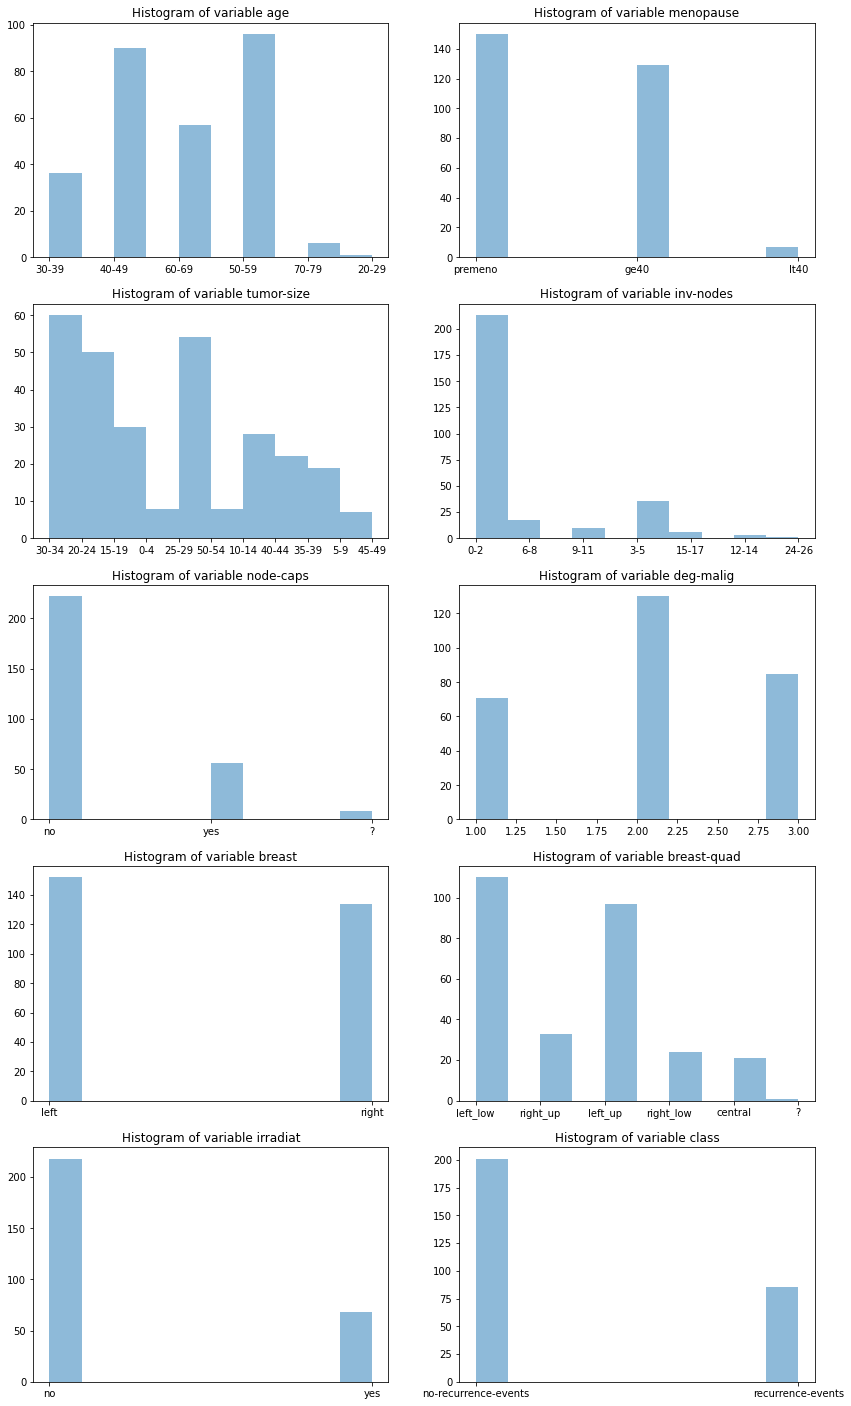

In [6]:
plt.rcParams["figure.figsize"] = (14,25)
for i in range(ncol):
    var = columns[i]
    place = ''.join(['52',str(i)])
    plt.subplot(place)
    plt.hist(df[var], alpha=0.5)
    plt.title(''.join(['Histogram of variable ',var]))
plt.show()

node-caps, breast-quad 변수에서 '?'값이 나타나 전처리가 필요하다.

In [7]:
df['node-caps'].unique()

array(['no', 'yes', '?'], dtype=object)

In [8]:
df[df['node-caps']=='?']

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
145,no-recurrence-events,40-49,premeno,25-29,0-2,?,2,left,right_low,yes
163,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_up,yes
164,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_low,yes
183,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_up,yes
184,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_low,yes
233,recurrence-events,70-79,ge40,15-19,9-11,?,1,left,left_low,yes
263,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_up,no
264,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_low,no


림프절 캡슐 내 종양 침투 여부를 알아내지 못한 것으로 파악되어 (missing value) 해당 관측치 삭제

In [9]:
df['breast-quad'].unique()

array(['left_low', 'right_up', 'left_up', 'right_low', 'central', '?'],
      dtype=object)

In [10]:
df[df['breast-quad']=='?']

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
206,recurrence-events,50-59,ge40,30-34,0-2,no,3,left,?,no


마찬가지로 사분면 파악을 못한 것으로 생각되어 (missing value) 해당 관측치 삭제

In [11]:
df1 = df.drop([145,163,164,183,184,233,263,264,206],axis=0)
df1 = df1.reset_index()
df1 = df1.drop('index', axis=1)
df1.shape
nrow = df1.shape[0]

### 순서형 변수는 평균값으로 대체

age, tumor-size, inv-nodes에 대해 순차적으로 대체

In [12]:
def to_mean(colname) :
    category = df1[colname].unique()
    for i in category:
        lower = int(i.split('-')[0])
        upper = int(i.split('-')[1])
        mean = (lower+upper)/2
        df1.loc[df1[colname]==i,colname]=mean
    print(colname, 'is changed to numeric variable')

In [13]:
to_mean('age')

age is changed to numeric variable


In [14]:
to_mean('tumor-size')

tumor-size is changed to numeric variable


In [15]:
to_mean('inv-nodes')

inv-nodes is changed to numeric variable


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        277 non-null    object
 1   age          277 non-null    object
 2   menopause    277 non-null    object
 3   tumor-size   277 non-null    object
 4   inv-nodes    277 non-null    object
 5   node-caps    277 non-null    object
 6   deg-malig    277 non-null    int64 
 7   breast       277 non-null    object
 8   breast-quad  277 non-null    object
 9   irradiat     277 non-null    object
dtypes: int64(1), object(9)
memory usage: 21.8+ KB


object type 변수를 float type으로

In [17]:
df1[['age','tumor-size','inv-nodes']]=df1[['age','tumor-size','inv-nodes']].apply(pd.to_numeric)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   class        277 non-null    object 
 1   age          277 non-null    float64
 2   menopause    277 non-null    object 
 3   tumor-size   277 non-null    float64
 4   inv-nodes    277 non-null    float64
 5   node-caps    277 non-null    object 
 6   deg-malig    277 non-null    int64  
 7   breast       277 non-null    object 
 8   breast-quad  277 non-null    object 
 9   irradiat     277 non-null    object 
dtypes: float64(3), int64(1), object(6)
memory usage: 21.8+ KB


breast와 breast-quad의 방향이 맞지 않는 변수 확인

In [18]:
df1['breast-q'] = df1['breast']
for i in range(nrow):
    df1['breast-q'].iloc[i] = df1['breast-quad'].iloc[i].split('_')[0]
df1[['breast','breast-q','breast-quad']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,breast,breast-q,breast-quad
0,left,left,left_low
1,right,right,right_up
2,left,left,left_low
3,right,left,left_up
4,right,right,right_low
...,...,...,...
272,left,left,left_up
273,left,left,left_up
274,right,left,left_up
275,left,left,left_low


In [19]:
# 다른 관측치의 합
sum(df1['breast']!=df1['breast-q'])

137

다른 관측치 수가 많기 때문에 breast의 방향과 breast-quad의 방향이 같은지를 나타내는 변수 생성

In [21]:
df1['breast_same'] = df['breast']
for i in range(nrow):
    if (df1['breast'].iloc[i] == df1['breast-q'].iloc[i]):
        df1['breast_same'].iloc[i] = 1
    else : 
        df1['breast_same'].iloc[i] = 0

df1['breast_same']

0      1
1      1
2      1
3      0
4      1
      ..
272    1
273    1
274    0
275    1
276    1
Name: breast_same, Length: 277, dtype: object

In [22]:
del df1['breast-q']

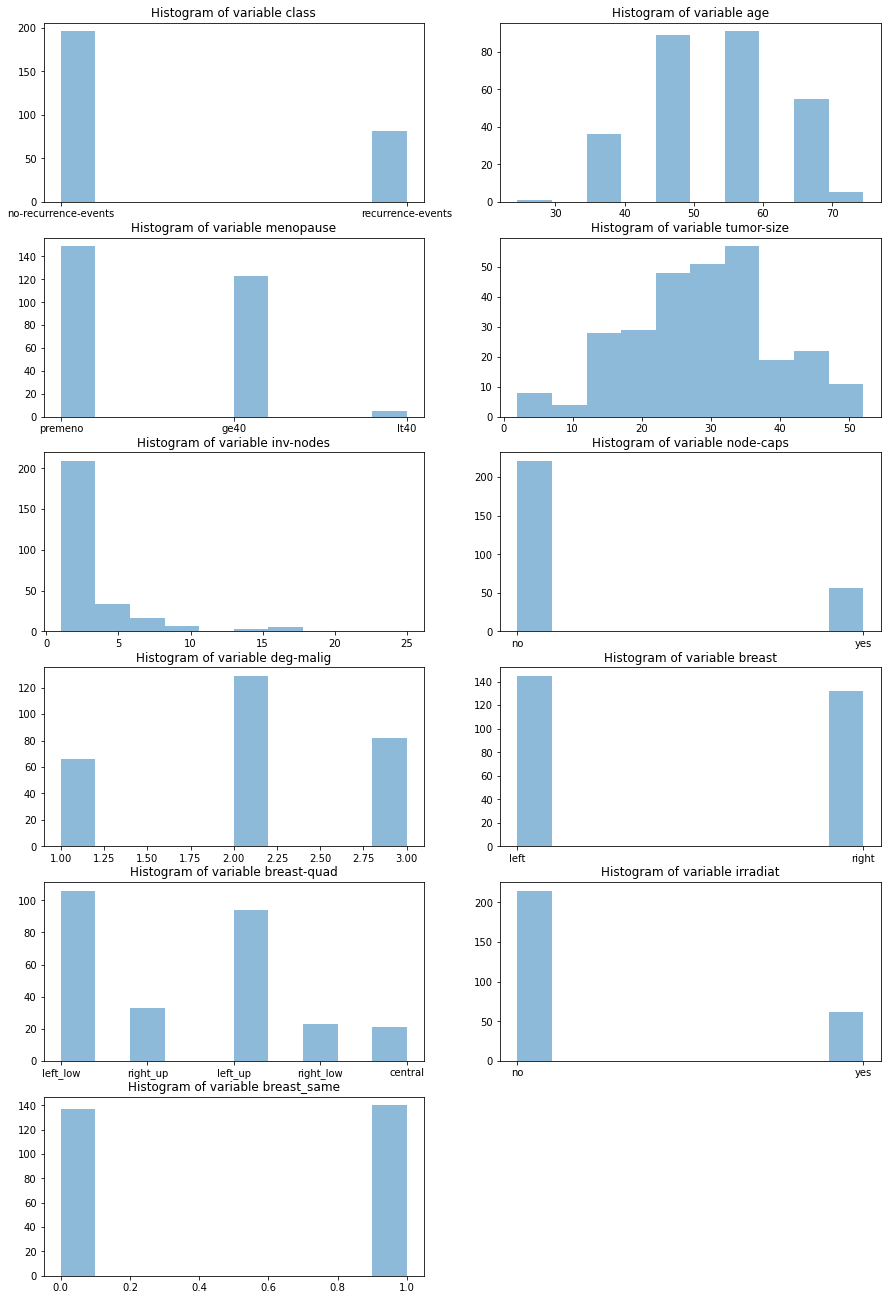

In [23]:
fig = plt.figure(figsize=(15,27))
columns = df1.columns
ncol = df1.shape[1]

for i in range(ncol):
    var = columns[i]
    plt.subplot(7,2,i+1)
    plt.hist(df1[var], alpha=0.5)
    plt.title(''.join(['Histogram of variable ',var]))
plt.show()

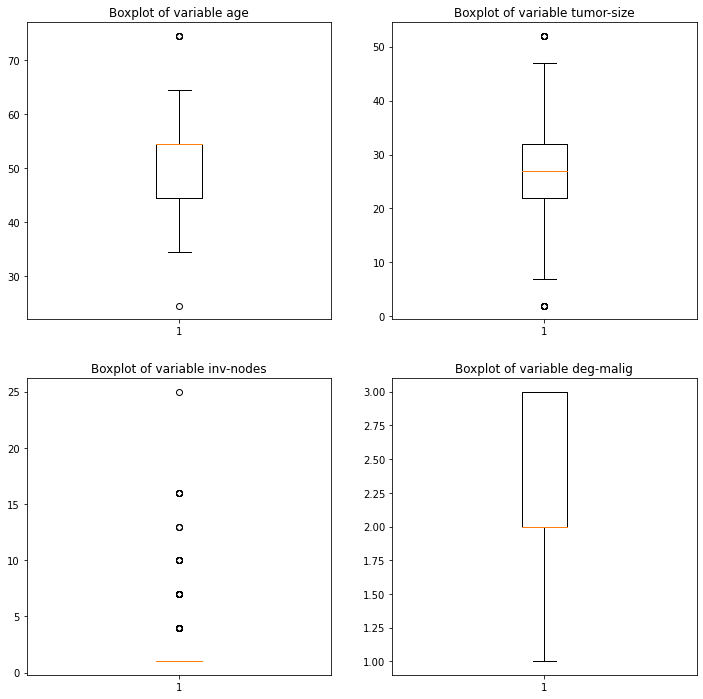

In [24]:
plt.rcParams["figure.figsize"] = (12,12)
for i in range(4):
    variables = ['age','tumor-size','inv-nodes','deg-malig']
    var = variables[i]
    place = ''.join(['22',str(i+1)])
    plt.subplot(place)
    plt.boxplot(df1[var])
    plt.title(''.join(['Boxplot of variable ',var]))
plt.show()

### dummy variable (one-hot encoding)

In [25]:
df_dummies = pd.get_dummies(df1['menopause'])
del df_dummies[df_dummies.columns[1]]

df_new = pd.concat([df1, df_dummies], axis=1)
del df_new['menopause']

In [26]:
df_dummies = pd.get_dummies(df1['node-caps'])
del df_dummies[df_dummies.columns[0]]
df_dummies.columns=['node-caps-yes']

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['node-caps']

In [27]:
df_dummies = pd.get_dummies(df1['breast'])
del df_dummies[df_dummies.columns[1]]
df_dummies.columns=['breast-left']

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['breast']

In [28]:
df_dummies = pd.get_dummies(df1['breast-quad'])
del df_dummies[df_dummies.columns[0]]

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['breast-quad']

In [29]:
df_dummies = pd.get_dummies(df1['irradiat'])
del df_dummies[df_dummies.columns[1]]
df_dummies.columns=['irradiat-no']

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['irradiat']

In [30]:
df_dummies = pd.get_dummies(df1['class'])
del df_dummies[df_dummies.columns[0]]

df_new = pd.concat([df_new, df_dummies], axis=1)
del df_new['class']

In [31]:
df_new

,age,tumor-size,inv-nodes,deg-malig,breast_same,ge40,premeno,node-caps-yes,breast-left,left_low,left_up,right_low,right_up,irradiat-no,recurrence-events
0,34.5,32.0,1.0,3,1,0,1,0,1,1,0,0,0,1,0
1,44.5,22.0,1.0,2,1,0,1,0,0,0,0,0,1,1,0
2,44.5,22.0,1.0,2,1,0,1,0,1,1,0,0,0,1,0
3,64.5,17.0,1.0,2,0,1,0,0,0,0,1,0,0,1,0
4,44.5,2.0,1.0,2,1,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,34.5,32.0,1.0,2,1,0,1,0,1,0,1,0,0,1,1
273,34.5,22.0,1.0,3,1,0,1,0,1,0,1,0,0,0,1
274,64.5,22.0,1.0,1,0,1,0,0,0,0,1,0,0,1,1
275,44.5,32.0,4.0,3,1,1,0,0,1,1,0,0,0,1,1


In [32]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                277 non-null    float64
 1   tumor-size         277 non-null    float64
 2   inv-nodes          277 non-null    float64
 3   deg-malig          277 non-null    int64  
 4   breast_same        277 non-null    object 
 5   ge40               277 non-null    uint8  
 6   premeno            277 non-null    uint8  
 7   node-caps-yes      277 non-null    uint8  
 8   breast-left        277 non-null    uint8  
 9   left_low           277 non-null    uint8  
 10  left_up            277 non-null    uint8  
 11  right_low          277 non-null    uint8  
 12  right_up           277 non-null    uint8  
 13  irradiat-no        277 non-null    uint8  
 14  recurrence-events  277 non-null    uint8  
dtypes: float64(3), int64(1), object(1), uint8(10)
memory usage: 13.7+ KB


In [33]:
# 상관관계 분석을 위해 object 변수를 numeric 변수로
df_new.iloc[:,4]=df_new.iloc[:,4].apply(pd.to_numeric)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                277 non-null    float64
 1   tumor-size         277 non-null    float64
 2   inv-nodes          277 non-null    float64
 3   deg-malig          277 non-null    int64  
 4   breast_same        277 non-null    int64  
 5   ge40               277 non-null    uint8  
 6   premeno            277 non-null    uint8  
 7   node-caps-yes      277 non-null    uint8  
 8   breast-left        277 non-null    uint8  
 9   left_low           277 non-null    uint8  
 10  left_up            277 non-null    uint8  
 11  right_low          277 non-null    uint8  
 12  right_up           277 non-null    uint8  
 13  irradiat-no        277 non-null    uint8  
 14  recurrence-events  277 non-null    uint8  
dtypes: float64(3), int64(2), uint8(10)
memory usage: 13.7 KB


### 상관관계 분석

In [34]:
df_new.corr()

,age,tumor-size,inv-nodes,deg-malig,breast_same,ge40,premeno,node-caps-yes,breast-left,left_low,left_up,right_low,right_up,irradiat-no,recurrence-events
age,1.000000,-0.004700,-0.064067,-0.065260,-0.006903,0.705907,-0.716330,-0.044446,0.041744,-0.000851,0.057436,-0.074996,-0.024379,0.075946,-0.086981
tumor-size,-0.004700,1.000000,0.163618,0.209259,0.076931,0.002230,0.012760,0.205537,-0.050005,0.009171,0.068768,-0.130673,0.161940,-0.168402,0.188848
inv-nodes,-0.064067,0.163618,1.000000,0.340156,0.049258,0.014574,0.001473,0.616589,0.014246,0.018370,-0.014567,0.062885,0.004322,-0.296590,0.295989
deg-malig,-0.065260,0.209259,0.340156,1.000000,0.028869,0.048813,-0.045776,0.330181,0.045874,-0.001251,0.058286,-0.041809,0.016729,-0.230821,0.330253
breast_same,-0.006903,0.076931,0.049258,0.028869,1.000000,-0.002413,0.010039,0.012527,0.516336,0.318306,-0.206011,-0.121016,0.163189,0.005816,0.000974
ge40,0.705907,0.002230,0.014574,0.048813,-0.002413,1.000000,-0.964229,-0.015675,0.052571,-0.015975,0.050025,-0.058273,-0.059514,0.061548,-0.047401
premeno,-0.716330,0.012760,0.001473,-0.045776,0.010039,-0.964229,1.000000,0.033847,-0.057940,0.014629,-0.054492,0.068969,0.050273,-0.080780,0.070514
node-caps-yes,-0.044446,0.205537,0.616589,0.330181,0.012527,-0.015675,0.033847,1.000000,0.012345,-0.007945,-0.019053,0.011408,0.064613,-0.333537,0.289002
breast-left,0.041744,-0.050005,0.014246,0.045874,0.516336,0.052571,-0.057940,0.012345,1.000000,0.290184,-0.232128,0.103742,-0.184626,0.025230,0.041304
left_low,-0.000851,0.009171,0.018370,-0.001251,0.318306,-0.015975,0.014629,-0.007945,0.290184,1.000000,-0.564278,-0.236920,-0.289546,-0.022710,0.032717


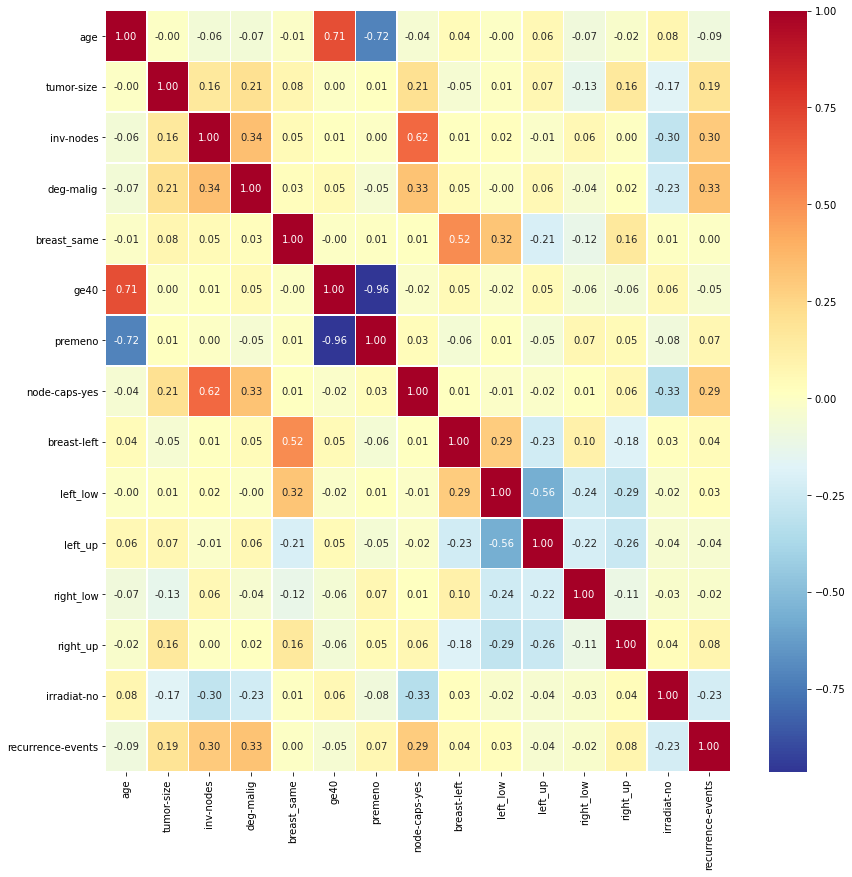

In [35]:
plt.figure(figsize=(14,14))
sns.heatmap(data=df_new.corr(method='pearson'), annot=True, fmt = '.2f', linewidths=.5, cmap='RdYlBu_r')

(age,ge40), (inv-nodes,node-caps-yes) 가 매우 강한 양의 상관관계를,  
(age,premeno), (ge40,premeno) 가 매우 강한 음의 상관관계를,   
(breast_same), (breast-left)가 강한 양의 상관관계를,  
(left_low,left_up) 가 강한 음의 상관관계를 가지는 것으로 보인다.

In [36]:
X1 = ['age','inv-nodes','age','ge40','breast_same','left_low']
X2 = ['ge40','node-caps-yes','premeno','premeno','breast-left','left_up']

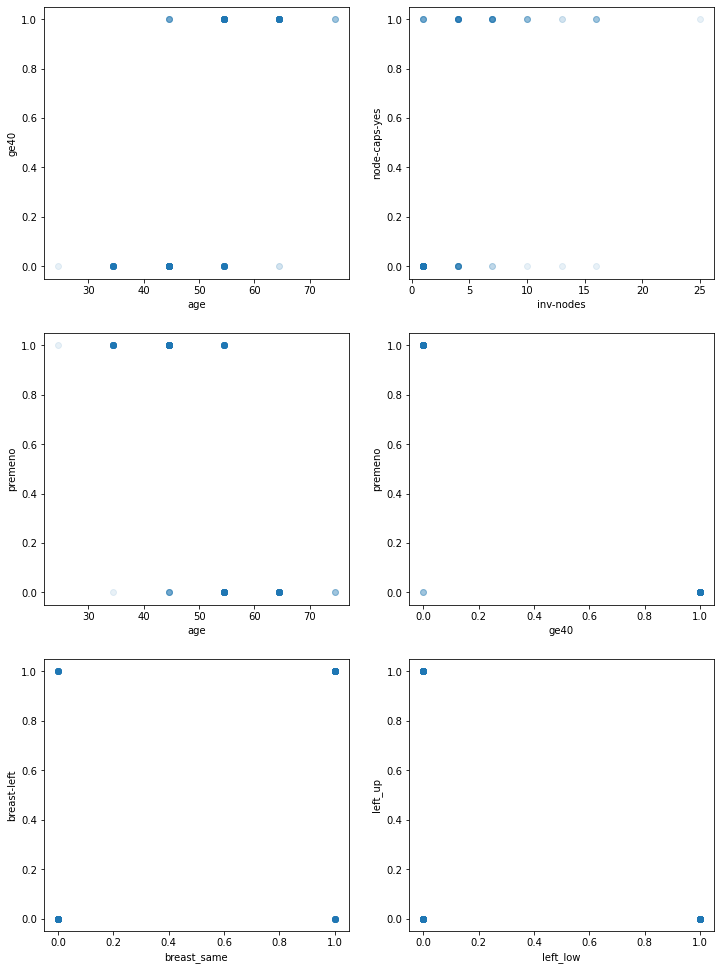

In [37]:
plt.rcParams["figure.figsize"] = (12,17)
for i in range(6):
    place = ''.join(['32',str(i+1)])
    plt.subplot(place)
    plt.scatter(df_new[X1[i]],df_new[X2[i]], alpha=0.1)
    plt.xlabel(X1[i])
    plt.ylabel(X2[i])
plt.show()

In [38]:
for i in range(6):
    print('{',X1[i],'&',X2[i],'}')
    print('Covariance: {:.2f}'.format(np.cov(df_new[X1[i]],df_new[X2[i]])[0,1]))
    print('Correlation: {:.2f}'.format(stats.pearsonr(df_new[X1[i]],df_new[X2[i]])[0]))
    print('P-value: {:.4f}'.format(stats.pearsonr(df_new[X1[i]],df_new[X2[i]])[1]))
    print('\n')

{ age & ge40 }
Covariance: 3.55
Correlation: 0.71
P-value: 0.0000


{ inv-nodes & node-caps-yes }
Covariance: 0.85
Correlation: 0.62
P-value: 0.0000


{ age & premeno }
Covariance: -3.61
Correlation: -0.72
P-value: 0.0000


{ ge40 & premeno }
Covariance: -0.24
Correlation: -0.96
P-value: 0.0000


{ breast_same & breast-left }
Covariance: 0.13
Correlation: 0.52
P-value: 0.0000


{ left_low & left_up }
Covariance: -0.13
Correlation: -0.56
P-value: 0.0000




귀무가설 '상관관계가 없다'가 기각되어 해당 변수들은 독립이 아니다.  
사실 categorical variable의 correlation을 통해 상관관계를 분석하는 것보다 chi-square test를 통해 상관관계를 살펴보는 것이 더 정확하다고 생각되어 이를 진행하였다.

### Pearson chi-square test

In [39]:
# contingency table
cont1 = pd.crosstab(df_new[X1[0]],df_new[X2[0]], margins=True)
cont2 = pd.crosstab(df_new[X1[1]],df_new[X2[1]], margins=True)
cont3 = pd.crosstab(df_new[X1[2]],df_new[X2[2]], margins=True)
cont4 = pd.crosstab(df_new[X1[3]],df_new[X2[3]], margins=True)
cont5 = pd.crosstab(df_new[X1[4]],df_new[X2[4]], margins=True)
cont6 = pd.crosstab(df_new[X1[5]],df_new[X2[5]], margins=True)

In [40]:
# Expected
def exact(i):
    cont = pd.crosstab(df_new[X1[i]],df_new[X2[i]], margins=True)
    without = pd.crosstab(df_new[X1[i]],df_new[X2[i]])
    nrow = cont.shape[0]-1
    ncol = cont.shape[1]-1
    exp = np.zeros((nrow,ncol))
    for j in range(nrow):
        for k in range(ncol):
            exp[j,k] = cont.iloc[j,ncol]*cont.iloc[nrow,k]/cont.iloc[nrow,ncol]
    lessthan5 = (exp<5).sum()/(nrow*ncol)
    if lessthan5 > 0.2 :
        print('Do Fisher Exact test')
    else :
        print('Do chi-square test')

In [41]:
for i in range(6):
    print('For pair number', i+1)
    exact(i)

For pair number 1
Do Fisher Exact test
For pair number 2
Do Fisher Exact test
For pair number 3
Do Fisher Exact test
For pair number 4
Do chi-square test
For pair number 5
Do chi-square test
For pair number 6
Do chi-square test


범주가 2개 이상이라서 Fisher's exact test 진행이 불가능했기 때문에 모든 pair에 대해 chi-square test를 진행하였다.

In [42]:
# chi square
def chi(var1,var2):
    stat, p, dof, expected = chi2_contingency(pd.crosstab(df_new[var1],df_new[var2]))
    alpha = 0.05
    print('P-value is {:.4f}'.format(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')

In [43]:
for i in range(6):
    print('{',X1[i],'&',X2[i],'}')
    chi(X1[i],X2[i])
    print('\n')

{ age & ge40 }
P-value is 0.0000
Dependent (reject H0)


{ inv-nodes & node-caps-yes }
P-value is 0.0000
Dependent (reject H0)


{ age & premeno }
P-value is 0.0000
Dependent (reject H0)


{ ge40 & premeno }
P-value is 0.0000
Dependent (reject H0)


{ breast_same & breast-left }
P-value is 0.0000
Dependent (reject H0)


{ left_low & left_up }
P-value is 0.0000
Dependent (reject H0)




In [44]:
# Fisher's exact test - 범주가 2개 이상이라서 계산 불가(rpy2 패키지 설치시 가능)
def fisher(var1,var2):
    oddsratio, pvalue = stats.fisher_exact(pd.crosstab(df_new[var1],df_new[var2]))
    alpha = 0.05
    print('P-value is {:.4f}'.format(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')

모든 pair가 연관되어 있다.

### 종속변수에 따른 변수들의 분포

In [45]:
# indicator variables를 object type으로
df_new.iloc[:,4:]=df_new.iloc[:,4:].astype(object)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                277 non-null    float64
 1   tumor-size         277 non-null    float64
 2   inv-nodes          277 non-null    float64
 3   deg-malig          277 non-null    int64  
 4   breast_same        277 non-null    object 
 5   ge40               277 non-null    object 
 6   premeno            277 non-null    object 
 7   node-caps-yes      277 non-null    object 
 8   breast-left        277 non-null    object 
 9   left_low           277 non-null    object 
 10  left_up            277 non-null    object 
 11  right_low          277 non-null    object 
 12  right_up           277 non-null    object 
 13  irradiat-no        277 non-null    object 
 14  recurrence-events  277 non-null    object 
dtypes: float64(3), int64(1), object(11)
memory usage: 32.6+ KB


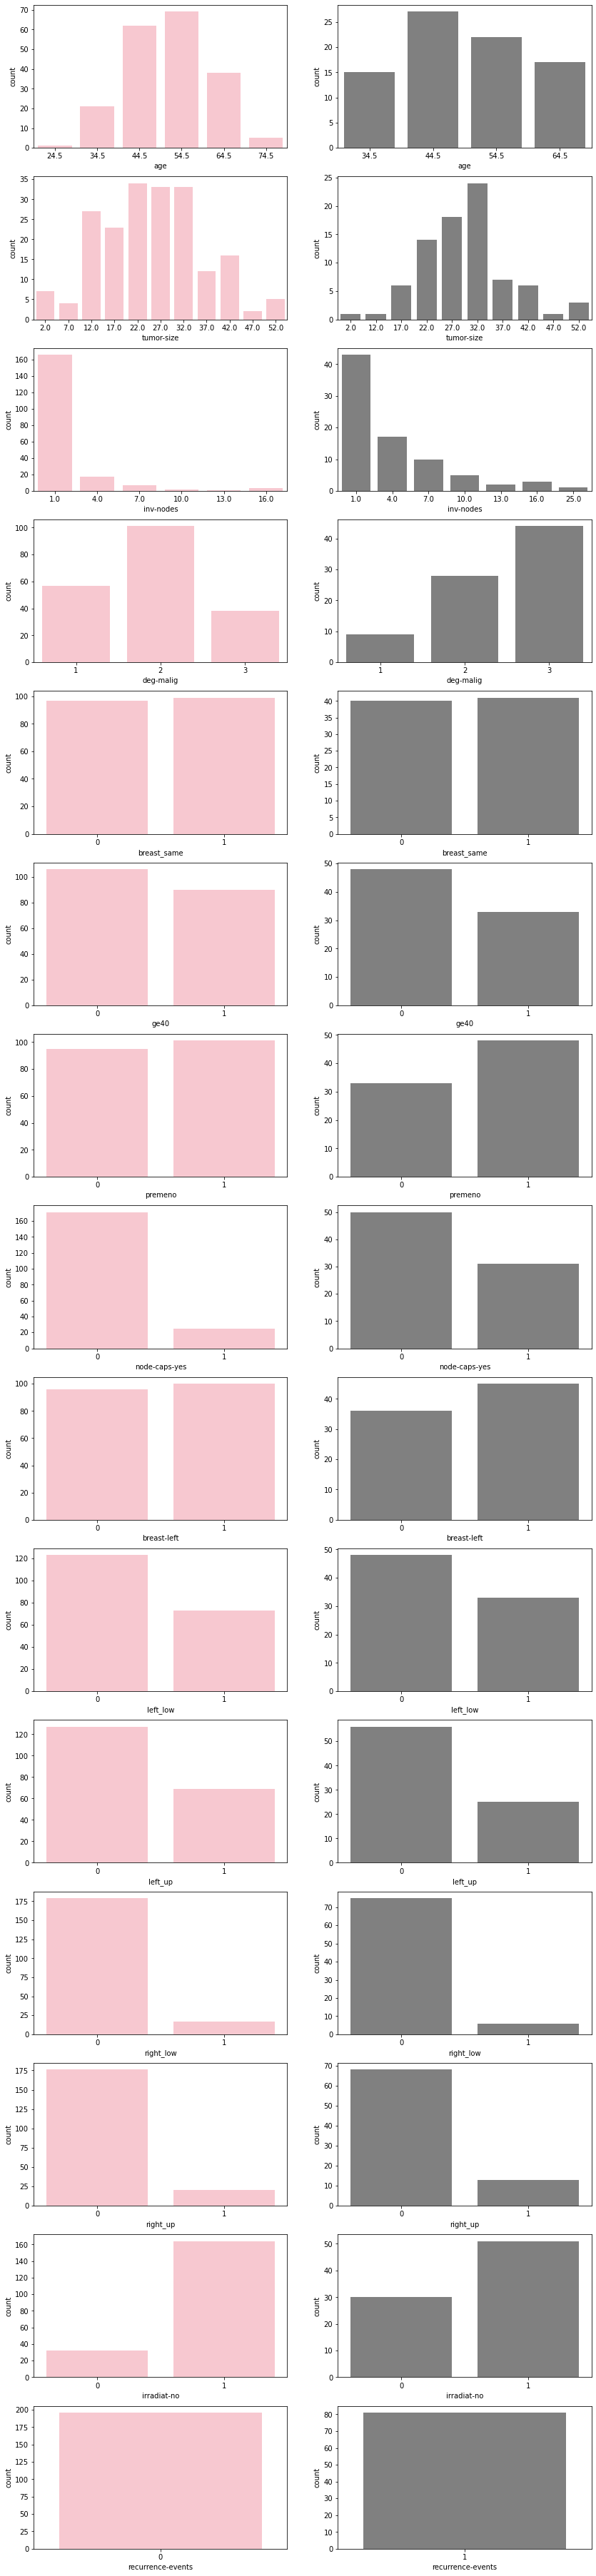

In [46]:
fig = plt.figure(figsize=(14,70))
grp_col_dict = {1:'gray',0:'pink'}
columns = df_new.columns
ncol = df_new.shape[1]

for i in range(ncol):
    var = columns[i]
    for group in grp_col_dict:
        subset = df_new[df_new['recurrence-events'] == group]
        if group==1:
            plt.subplot(16,2,2*i+2)
            sns.countplot(subset[columns[i]], color = grp_col_dict[group], label = group)
        else :
            plt.subplot(16,2,2*i+1)
            sns.countplot(subset[columns[i]], color = grp_col_dict[group], label = group)
plt.show()

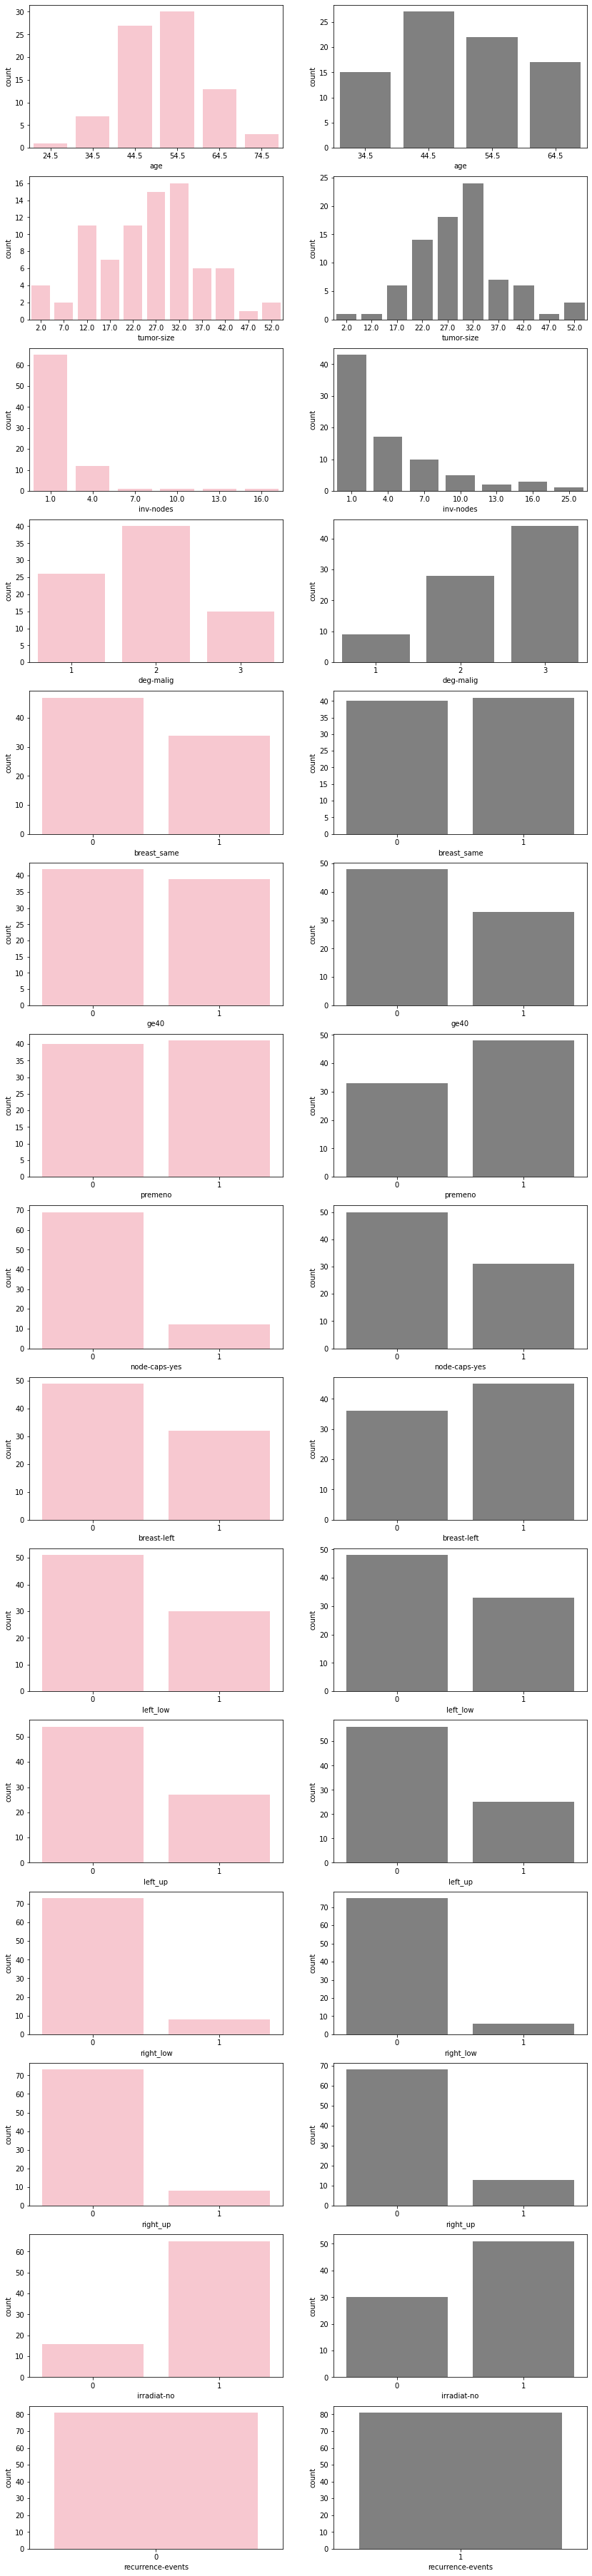

In [47]:
# class 비율 같게 해서 확인
fig = plt.figure(figsize=(14,70))
grp_col_dict = {1:'gray',0:'pink'}
smaller = df_new[df_new['recurrence-events'] == 1].shape[0]

for i in range(ncol):
    var = columns[i]
    for group in grp_col_dict:
        subset = df_new[df_new['recurrence-events'] == group]
        nrow = subset.shape[0]
        if group==1:
            plt.subplot(16,2,2*i+2)
            sns.countplot(subset[columns[i]], color = grp_col_dict[group], label = group)
        else :
            subset = subset.sample(n=smaller,random_state=0)
            plt.subplot(16,2,2*i+1)
            sns.countplot(subset[columns[i]], color = grp_col_dict[group], label = group)
plt.show()

deg-malig, breast_same, node-caps-yes, breast-left가 재발여부에 따라 다른 분포를 가진다.  
breast-quad는 재발여부에 관계없이 비슷한 분포를 가진다.

# Modeling

In [48]:
X = df_new.drop('recurrence-events', axis=1)
y = df_new['recurrence-events'] 

In [49]:
from sklearn.preprocessing import LabelEncoder
classle = LabelEncoder() 
y = classle.fit_transform(y.values) 

In [50]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(193, 14)
(84, 14)
(193,)
(84,)


In [51]:
# X에 대해 표준화 진행
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

## Stratified kfold cross validation - simple model

SVC  
Decision Tree  
AdaBoost  
Random Forest  
Extra Trees  
Multiple layer perceprton (neural network)  
KNN  
Logistic regression  
Linear Discriminant Analysis  

In [52]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [53]:
kfold = StratifiedKFold(n_splits=5)

random_state = 2
max_iter = 100000
classifiers = []
classifiers.append(SVC(random_state=random_state, max_iter=max_iter))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state, max_iter=max_iter))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [54]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

In [55]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [56]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.704318,0.053101,SVC
1,0.663293,0.053954,DecisionTree
2,0.611336,0.043836,AdaBoost
3,0.642510,0.037624,RandomForest
4,0.611201,0.055803,ExtraTrees
5,0.647773,0.033679,GradientBoosting
6,0.647233,0.060704,MultipleLayerPerceptron
7,0.683806,0.020992,KNeighboors
8,0.704723,0.051021,LogisticRegression
9,0.704723,0.034902,LinearDiscriminantAnalysis


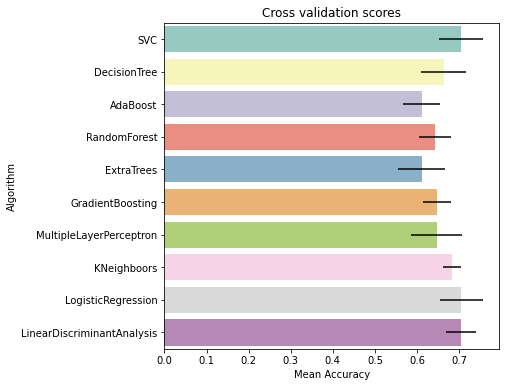

In [57]:
plt.figure(figsize=(6,6))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

SVC, LogisticRegression, LDA가 좋은 성능을 보인다.  
분산까지 고려했을 때 LDA가 가장 좋은 모델처럼 보인다.

### Hyperparameter tunning

AdaBoost, ExtraTrees , RandomForest, SVC

In [58]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train,y_train)
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 281 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    1.0s finished


0.6947368421052632

In [59]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_train,y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   40.6s finished


0.7306342780026991

In [60]:
# RFC
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   45.5s finished


0.735897435897436

In [61]:
# SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(X_train,y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    1.1s finished


0.7202429149797571

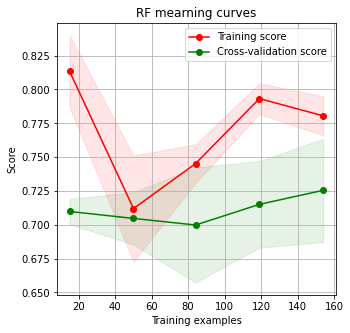

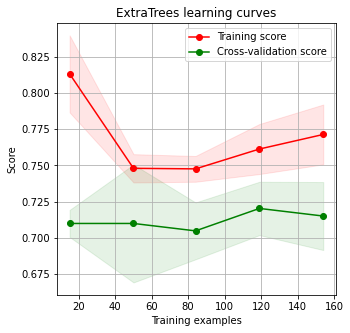

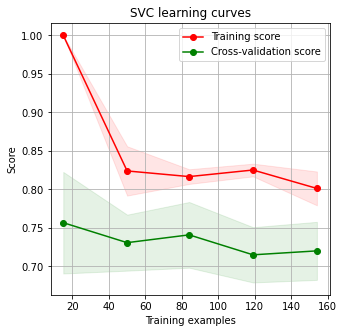

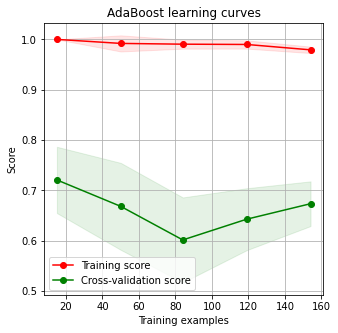

In [62]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(5,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)

AdaBoost가 특히 과적합되는 모습을 보인다.  
GradientBoosting은 training example 수가 증가함에 따라 두 그래프간 차이가 줄어드는 것으로부터 일반화에 유리할 것으로 보인다.

In [63]:
X_train_ = pd.DataFrame(X_train)
X_train_.columns = columns[:14]
X_train = X_train_

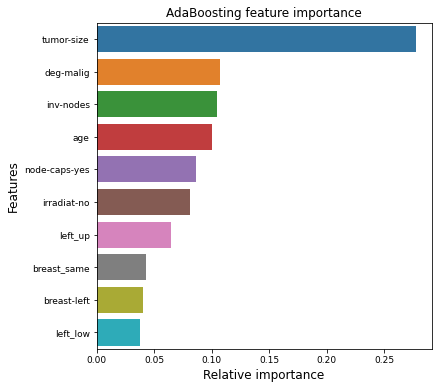

In [64]:
names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best)]

def importance(nclassifier):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:10]
    g = sns.barplot(y=X_train.columns[indices][:10],x = classifier.feature_importances_[indices][:10] , orient='h')
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    
plt.figure(figsize=(6,6))
importance(0)

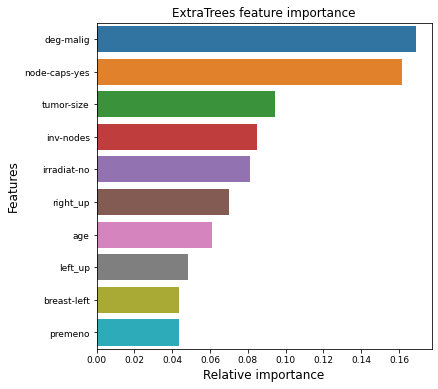

In [65]:
plt.figure(figsize=(6,6))
importance(1)

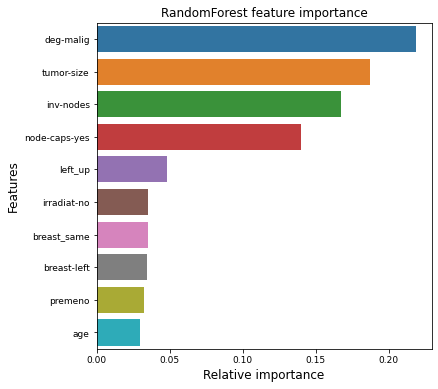

In [66]:
plt.figure(figsize=(6,6))
importance(2)

tumor-size, inv-nodes, deg-malig, node-caps-yes, irradiat-no, left_up, breast_same, breast-left, age가 공통적으로 영향을 많이 미친 변수 10순위 안에 들었다.  
그 중 (inv-nodes, node-caps-yes), (breast_same, breast_left)는 높은 상관관계를 가졌던 변수이다.  

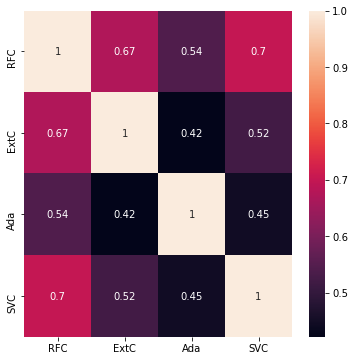

In [67]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC, test_Survived_SVMC],axis=1)

plt.figure(figsize=(6,6))
g= sns.heatmap(ensemble_results.corr(),annot=True)

## Ensemble modeling

In [68]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac',ada_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [69]:
test_Survived = pd.Series(votingC.predict(X_test))
score = sum(pd.Series(y_test)==test_Survived)/84
score

0.7976190476190477

## Dimensionality Reduction

PCA

In [70]:
from sklearn.decomposition import PCA

In [71]:
scov=np.cov(X_train.T)
eigen_vals, eigen_vecs=np.linalg.eig(scov)
print('Eigenvalues \n%s' %eigen_vals)

Eigenvalues 
[2.67179705 2.18419815 2.03980916 1.346311   1.27031538 0.01935758
 0.07546045 1.06213713 0.34864903 0.38107452 0.42526884 0.65528897
 0.83270323 0.76054617]


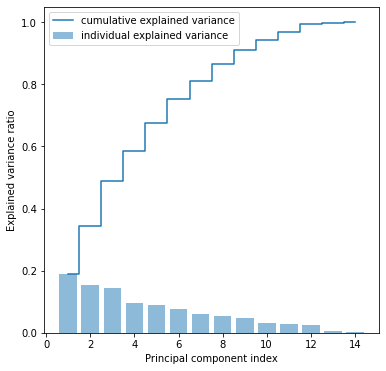

In [72]:
# Explained variance ratio
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(6,6))
plt.bar(range(1,15), var_exp, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1,15), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [73]:
pca = PCA(n_components=6) # 6개의 components 선택 시 전체 variance의 75% 설명 가능
X_train_pca = pca.fit_transform(X_train) #PCA는 비지도학습
X_test_pca = pca.transform(X_test)

print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.18985382 0.15520579 0.14494573 0.09566681 0.09026667 0.07547385]


0.7514126697595943

In [74]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train_pca, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [75]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.704858,0.029318,SVC
1,0.626856,0.058208,DecisionTree
2,0.663293,0.066369,AdaBoost
3,0.647638,0.042053,RandomForest
4,0.647368,0.044394,ExtraTrees
5,0.632254,0.051261,GradientBoosting
6,0.642240,0.061442,MultipleLayerPerceptron
7,0.658300,0.056601,KNeighboors
8,0.719973,0.046472,LogisticRegression
9,0.730364,0.054940,LinearDiscriminantAnalysis


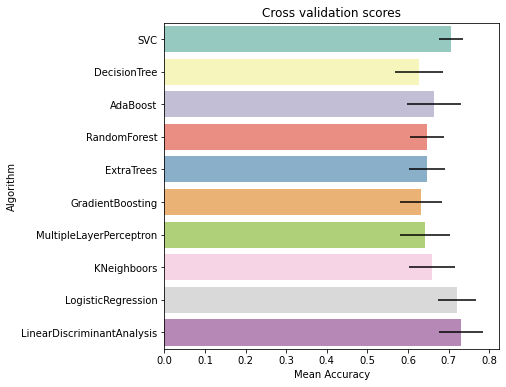

In [76]:
plt.figure(figsize=(6,6))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

정확도 측면에서 이전 모델보다 오히려 향상된 성능을 가지는 모델도 있어 보인다.  
설명변수 간 correlation이 사라진 결과로 생각된다.  
위와 같은 hyperparameter tunning, ensemble learning 을 진행하였다.

In [77]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train_pca,y_train)
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_ # 0.695

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    1.5s finished


0.6834008097165991

In [78]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_train_pca,y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_ # 0.731

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.2s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   40.7s finished


0.7098515519568152

In [79]:
# RFC
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train_pca,y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_ # 0.741

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   44.4s finished


0.7148448043184886

In [80]:
# SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(X_train,y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_ # 0.7202

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    1.2s finished


0.7202429149797571

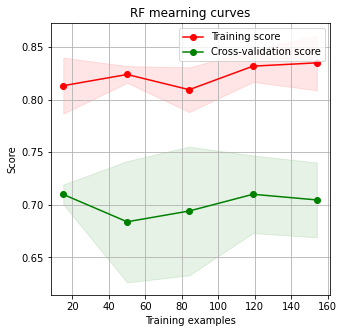

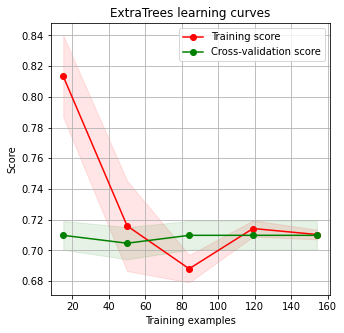

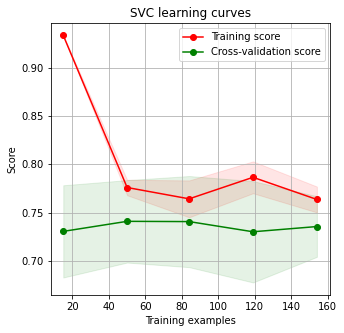

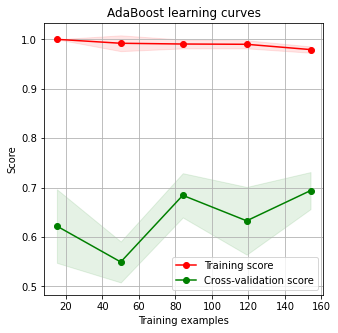

In [81]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train_pca,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train_pca,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train_pca,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train_pca,y_train,cv=kfold)

RF, AdaBoost 모델에서 과적합이 일어났지만 Extratrees, SVC 모델에서는 training example 수가 증가함에 따라 과적합 현상이 사라지는 것으로 보인다. 

In [82]:
votingC = votingC.fit(X_train_pca, y_train)

test_Survived = pd.Series(votingC.predict(X_test_pca))
score = sum(pd.Series(y_test)==test_Survived)/84
score # 0.786

0.7142857142857143